## This notebook does decoding (both 1D and 2D), acausal
This notebook is for all sessions.

In [25]:
%reload_ext autoreload
%autoreload 2

In [26]:
import spyglass as nd
import pandas as pd
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import os
import cupy as cp

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [28]:
from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_position import IntervalLinearizedPosition

import spyglass.spikesorting.v0 as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

from replay_trajectory_classification.environments import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters
from replay_trajectory_classification import ClusterlessClassifier



import pprint
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import EpochPos,TrialChoice,Decode,DecodeIngredients,DecodeResultsLinear,MUA,DecodeIngredientsLikelihood
from spyglass.shijiegu.decodeHelpers import (thresholder_sort,runSessionNames,populateUnitMarks,intersectValidIntervals)
from spyglass.shijiegu.helpers import interpolate_to_new_time

In [29]:
cp.show_config()

OS                           : Linux-5.15.0-136-generic-x86_64-with-glibc2.35
Python Version               : 3.9.18
CuPy Version                 : 13.2.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 1.23.5
SciPy Version                : 1.12.0
Cython Build Version         : 0.29.37
Cython Runtime Version       : None
CUDA Root                    : /usr/local/cuda
nvcc PATH                    : /usr/local/cuda/bin/nvcc
CUDA Build Version           : 11080
CUDA Driver Version          : 12020
CUDA Runtime Version         : 11080 (linked to CuPy) / 11060 (locally installed)
cuBLAS Version               : (available)
cuFFT Version                : 10600
cuRAND Version               : 10209
cuSOLVER Version             : (11, 3, 2)
cuSPARSE Version             : (available)
NVRTC Version                : (11, 6)
Thrust Version               : 200200
CUB Build Version            : 200200
Jitify Build Version         : <unknown>
cuDNN Build Version          : 8907

### 1. Obtain mark and position from `DecodeIngredients`, which is filled in DecodingPrep.ipynb

In [30]:
# find an idle GPU
#cp.show_config()
GPU_ID = 1
likelihood_flag = False

In [31]:
SPEED_THRESHOLD = 4
if SPEED_THRESHOLD == 0:
    encoding_set = 'all_maze'
else:
    encoding_set = '2Dheadspeed_above_'+str(SPEED_THRESHOLD)
#encoding_set = encoding_set + '_andlowmua'

window_size = 0.04
overlap_size = 0.02

### The parameters does not store the track environment itself, so fetch parameters and make an environment.

In [32]:
from replay_trajectory_classification.environments import Environment

def make_environment(parameters, track_name, causal_flag = False, likelihood_flag = False, window_size = None, overlap_size = None):
    # this function updates the parameters to add environment variables
    # The parameters in Spyglass does not store the track environment itself, so fetch parameters and make an environment.
    # parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_gpu_4armMaze'}).fetch1()
    # track_name = parameters['classifier_params']['environments'][0].environment_name
    # window_size and overlap_size only val
    track_graph = (TrackGraph() & {'track_graph_name': track_name}).get_networkx_track_graph()
    track_graph_params = (TrackGraph() & {'track_graph_name': track_name}).fetch1()
    
    
    
    if causal_flag:
        classifier_param_name = 'causal_decoding_gpu_4armMaze'
        parameters['classifier_param_name'] = classifier_param_name
        parameters['predict_params']['is_compute_acausal'] = False
    else:
        classifier_param_name = 'default_decoding_gpu_4armMaze'
        parameters['classifier_param_name'] = classifier_param_name

    if likelihood_flag:
        classifier_param_name += "_W"+str(int(window_size*1000)) + "msO" + str(int(overlap_size*1000)) +"ms"
        parameters['classifier_param_name'] = classifier_param_name
    print(parameters['classifier_param_name'])

    #ClusterlessClassifierParameters().insert1(parameters, replace = False)

    parameters['classifier_params']['environments'] = [
        Environment(
        track_graph=track_graph,
        edge_order=track_graph_params['linear_edge_order'],
        edge_spacing=track_graph_params['linear_edge_spacing'])]
    return parameters, classifier_param_name
    
    

In [35]:
parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_gpu_4armMaze'}).fetch1()
track_name = parameters['classifier_params']['environments'][0].environment_name

if likelihood_flag:
    parameters, classifier_param_name = make_environment(parameters, track_name, causal_flag = False,
                                  likelihood_flag = True, window_size = window_size, overlap_size = overlap_size)
else:
    parameters, classifier_param_name = make_environment(parameters, track_name, causal_flag = False,
                                  likelihood_flag = False)


[14:56:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
10-Apr-25 14:56:46 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[14:56:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
10-Apr-25 14:56:46 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


default_decoding_gpu_4armMaze


In [36]:
nwb_copy_file_name_all = ['molly20220420_.nwb']

In [37]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name_all[0])

In [38]:
session_interval

['02_Seq2Session1',
 '04_Seq2Session2',
 '06_Seq2Session3',
 '08_Seq2Session4',
 '10_Seq2Session5',
 '12_Seq2Session6']

In [39]:
if likelihood_flag:
    print(DecodeIngredientsLikelihood & {'nwb_file_name':nwb_copy_file_name_all[0]})
else:
    print(DecodeIngredients & {'nwb_file_name':nwb_copy_file_name_all[0]})

*nwb_file_name *interval_list marks      position_1 position_2
+------------+ +------------+ +--------+ +--------+ +--------+
molly20220420_ 02_Seq2Session =BLOB=     =BLOB=     =BLOB=    
molly20220420_ 04_Seq2Session =BLOB=     =BLOB=     =BLOB=    
molly20220420_ 06_Seq2Session =BLOB=     =BLOB=     =BLOB=    
molly20220420_ 08_Seq2Session =BLOB=     =BLOB=     =BLOB=    
molly20220420_ 10_Seq2Session =BLOB=     =BLOB=     =BLOB=    
molly20220420_ 12_Seq2Session =BLOB=     =BLOB=     =BLOB=    
 (Total: 6)



In [ ]:
for nwb_copy_file_name in nwb_copy_file_name_all:
    session_interval, position_interval = runSessionNames(nwb_copy_file_name)
    for e in range(len(session_interval)):
        if likelihood_flag:
            entry = DecodeIngredientsLikelihood & {'nwb_file_name':nwb_copy_file_name,
             'interval_list_name':session_interval[e],
             "window_size":window_size,"overlap_size":overlap_size}
        else:
            entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
             'interval_list_name':session_interval[e]}
        print(entry)
    
        # Get data
        marks = xr.open_dataset(entry.fetch1('marks'))
        position_1d = pd.read_csv(entry.fetch1('position_1d'))
        position_2d = pd.read_csv(entry.fetch1('position_2d')) #still need 2D position

        """
        mua_path=(MUA & {'nwb_file_name': nwb_copy_file_name,
                     'interval_list_name':session_interval[e]}).fetch1('mua_trace')
        mua_xr = xr.open_dataset(mua_path)
        mua_threshold=(MUA & {'nwb_file_name': nwb_copy_file_name,
                    'interval_list_name':session_interval[e]}).fetch1('mean')
        mua_downsample = (interpolate_to_new_time(mua_xr.to_dataframe(), position_1d.time)).to_xarray()
        
        lowMua_index = mua_downsample.mua < mua_threshold
        """
        immobility_ind = position_2d.head_speed < SPEED_THRESHOLD
        
        mobility_ind = position_2d.head_speed >= SPEED_THRESHOLD
        #encoding_time_index = np.argwhere(np.logical_or(np.logical_and(np.array(immobility_ind),
        #                                         np.array(lowMua_index)),
        #                          np.array(mobility_ind))).ravel()
        encoding_time_index = np.argwhere(np.array(mobility_ind)).ravel()
        mark_mobility = marks.isel(time=encoding_time_index)
        mark_mobility_np = np.array(mark_mobility.to_dataarray()).squeeze()
    
        position_1d_mobility = position_1d.iloc[encoding_time_index]
    
        # use context manager to specify which GPU (device)
        with cp.cuda.Device(GPU_ID):
        
            classifier = ClusterlessClassifier(**parameters['classifier_params'])
        
            # choose movement data only to fit
            mobility_ind = position_2d.head_speed >= SPEED_THRESHOLD
            position_1d_mobility = position_1d.loc[mobility_ind]
            mark_mobility = marks.isel(time=np.argwhere(np.array(mobility_ind)).ravel())
            mark_mobility_np = np.array(mark_mobility.to_dataarray()).squeeze()
            
            
            classifier.fit(
                position=position_1d_mobility.linear_position.values,
                multiunits=mark_mobility_np,
                **parameters['fit_params']
            )
        
            
            # predict all data
            marks_np = np.array(marks.to_dataarray()).squeeze()
            
            results = classifier.predict(
                multiunits=marks_np,
                time=np.array(position_1d.time),
                **parameters['predict_params']
            )
            logging.info('Done!')
        
        animal = nwb_copy_file_name[:5]
        decode_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                                 nwb_copy_file_name+'_'+session_interval[e]+'_'+encoding_set+'_'+classifier_param_name+'_result.nc')
        results.to_netcdf(decode_path)
    
        key={'nwb_file_name':nwb_copy_file_name,
             'interval_list_name':session_interval[e],
             'classifier_param_name':parameters['classifier_param_name'],
             'encoding_set':encoding_set,
             'posterior':decode_path,
        }
        DecodeResultsLinear().insert1(key,replace=True)


*nwb_file_name *interval_list marks      position_1 position_2
+------------+ +------------+ +--------+ +--------+ +--------+
molly20220420_ 02_Seq2Session =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)



10-Apr-25 14:56:51 Fitting initial conditions...
10-Apr-25 14:56:51 Fitting continuous state transition...
10-Apr-25 14:56:52 Fitting discrete state transition
10-Apr-25 14:56:52 Fitting multiunits...
10-Apr-25 14:56:56 Estimating likelihood...


n_electrodes:   0%|          | 0/25 [00:00<?, ?it/s]

10-Apr-25 14:57:20 Estimating causal posterior...
10-Apr-25 14:58:52 Estimating acausal posterior...
10-Apr-25 15:02:21 Done!


*nwb_file_name *interval_list marks      position_1 position_2
+------------+ +------------+ +--------+ +--------+ +--------+
molly20220420_ 04_Seq2Session =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)



10-Apr-25 15:02:51 Fitting initial conditions...
10-Apr-25 15:02:51 Fitting continuous state transition...
10-Apr-25 15:02:53 Fitting discrete state transition
10-Apr-25 15:02:53 Fitting multiunits...
10-Apr-25 15:02:56 Estimating likelihood...


n_electrodes:   0%|          | 0/25 [00:00<?, ?it/s]

10-Apr-25 15:03:38 Estimating causal posterior...
10-Apr-25 15:09:35 Estimating acausal posterior...


In [41]:
DecodeResultsLinear() & {'nwb_file_name':nwb_copy_file_name_all[0]}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,classifier_param_name a name for this set of parameters,encoding_set a name for this set of encoding,posterior posterior within that interval (1D)
molly20220420_.nwb,02_Seq2Session1,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=
molly20220420_.nwb,04_Seq2Session2,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=
molly20220420_.nwb,06_Seq2Session3,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=
molly20220420_.nwb,08_Seq2Session4,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=
molly20220420_.nwb,10_Seq2Session5,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=
molly20220420_.nwb,12_Seq2Session6,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=


Finally, we can plot the decodes to make sure they make sense.

### Quickly check individual session's.

NameError: name 'results' is not defined

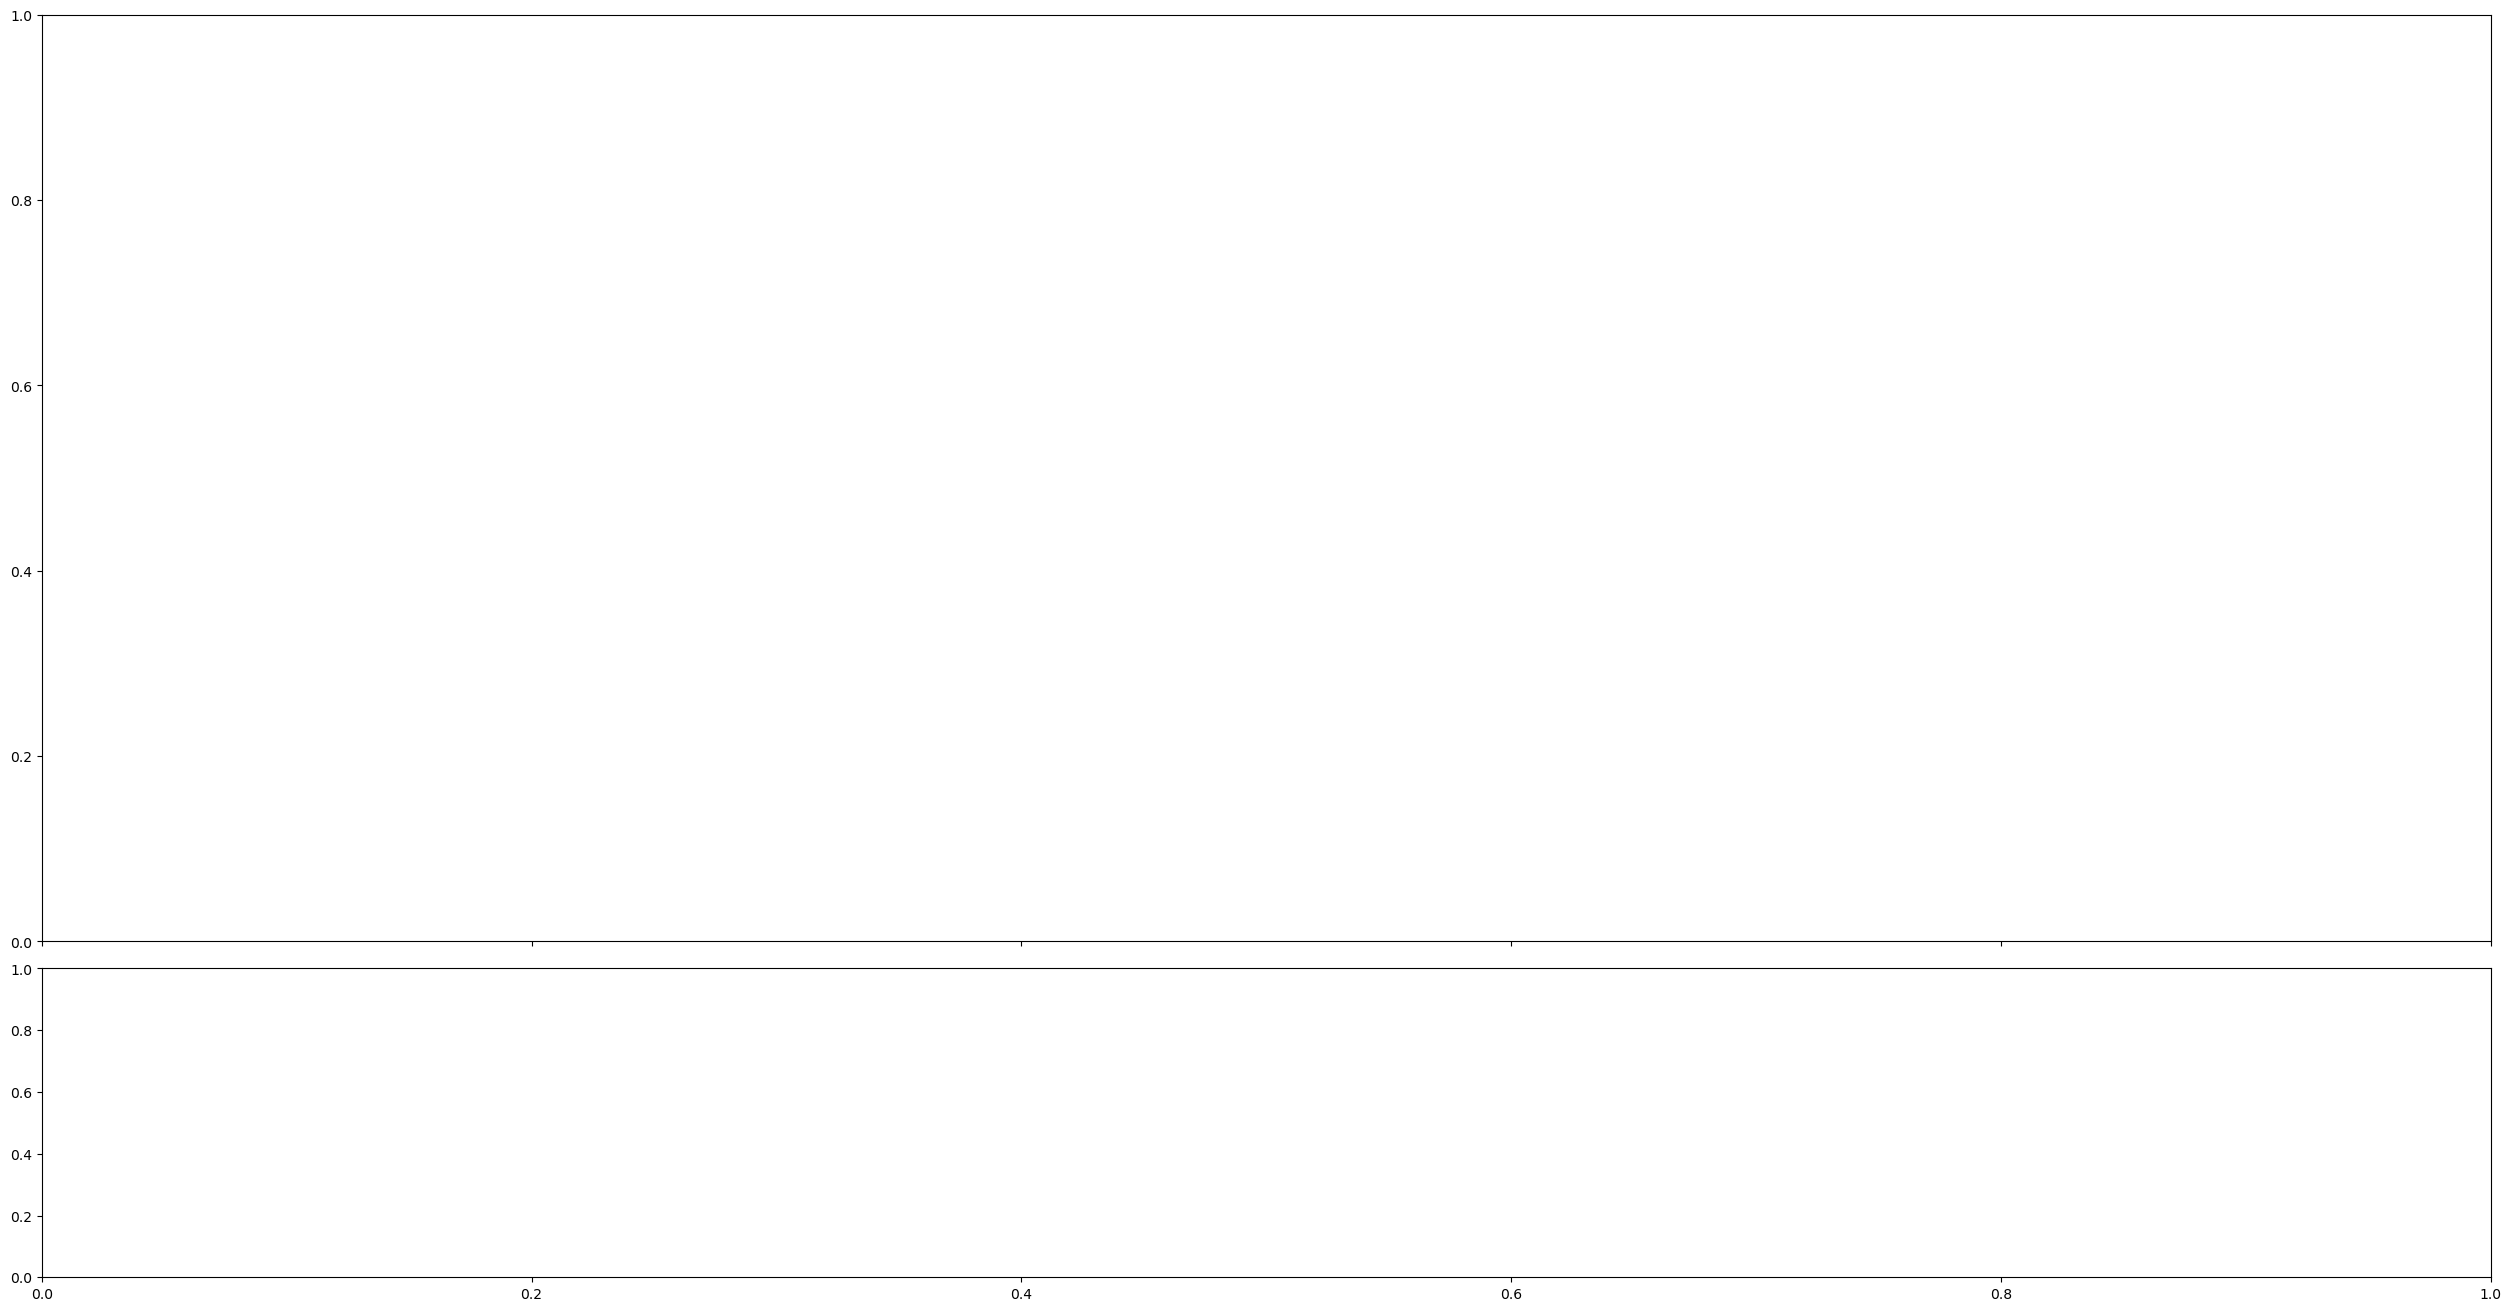

In [13]:
import matplotlib.pyplot as plt
for time_ind in range(0, 100_000, 10_000): #range(0, 600_000, 100_000)
    time_slice = slice(time_ind, time_ind + 30_000)

    fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)
    results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position',
                                                                      ax=axes[0], robust=True, cmap='bone_r',rasterized = True)
    axes[0].scatter(position_1d.iloc[time_slice].time,
                    position_1d.iloc[time_slice].linear_position.values,
                    s=1, color='magenta', zorder=10)
 
    results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

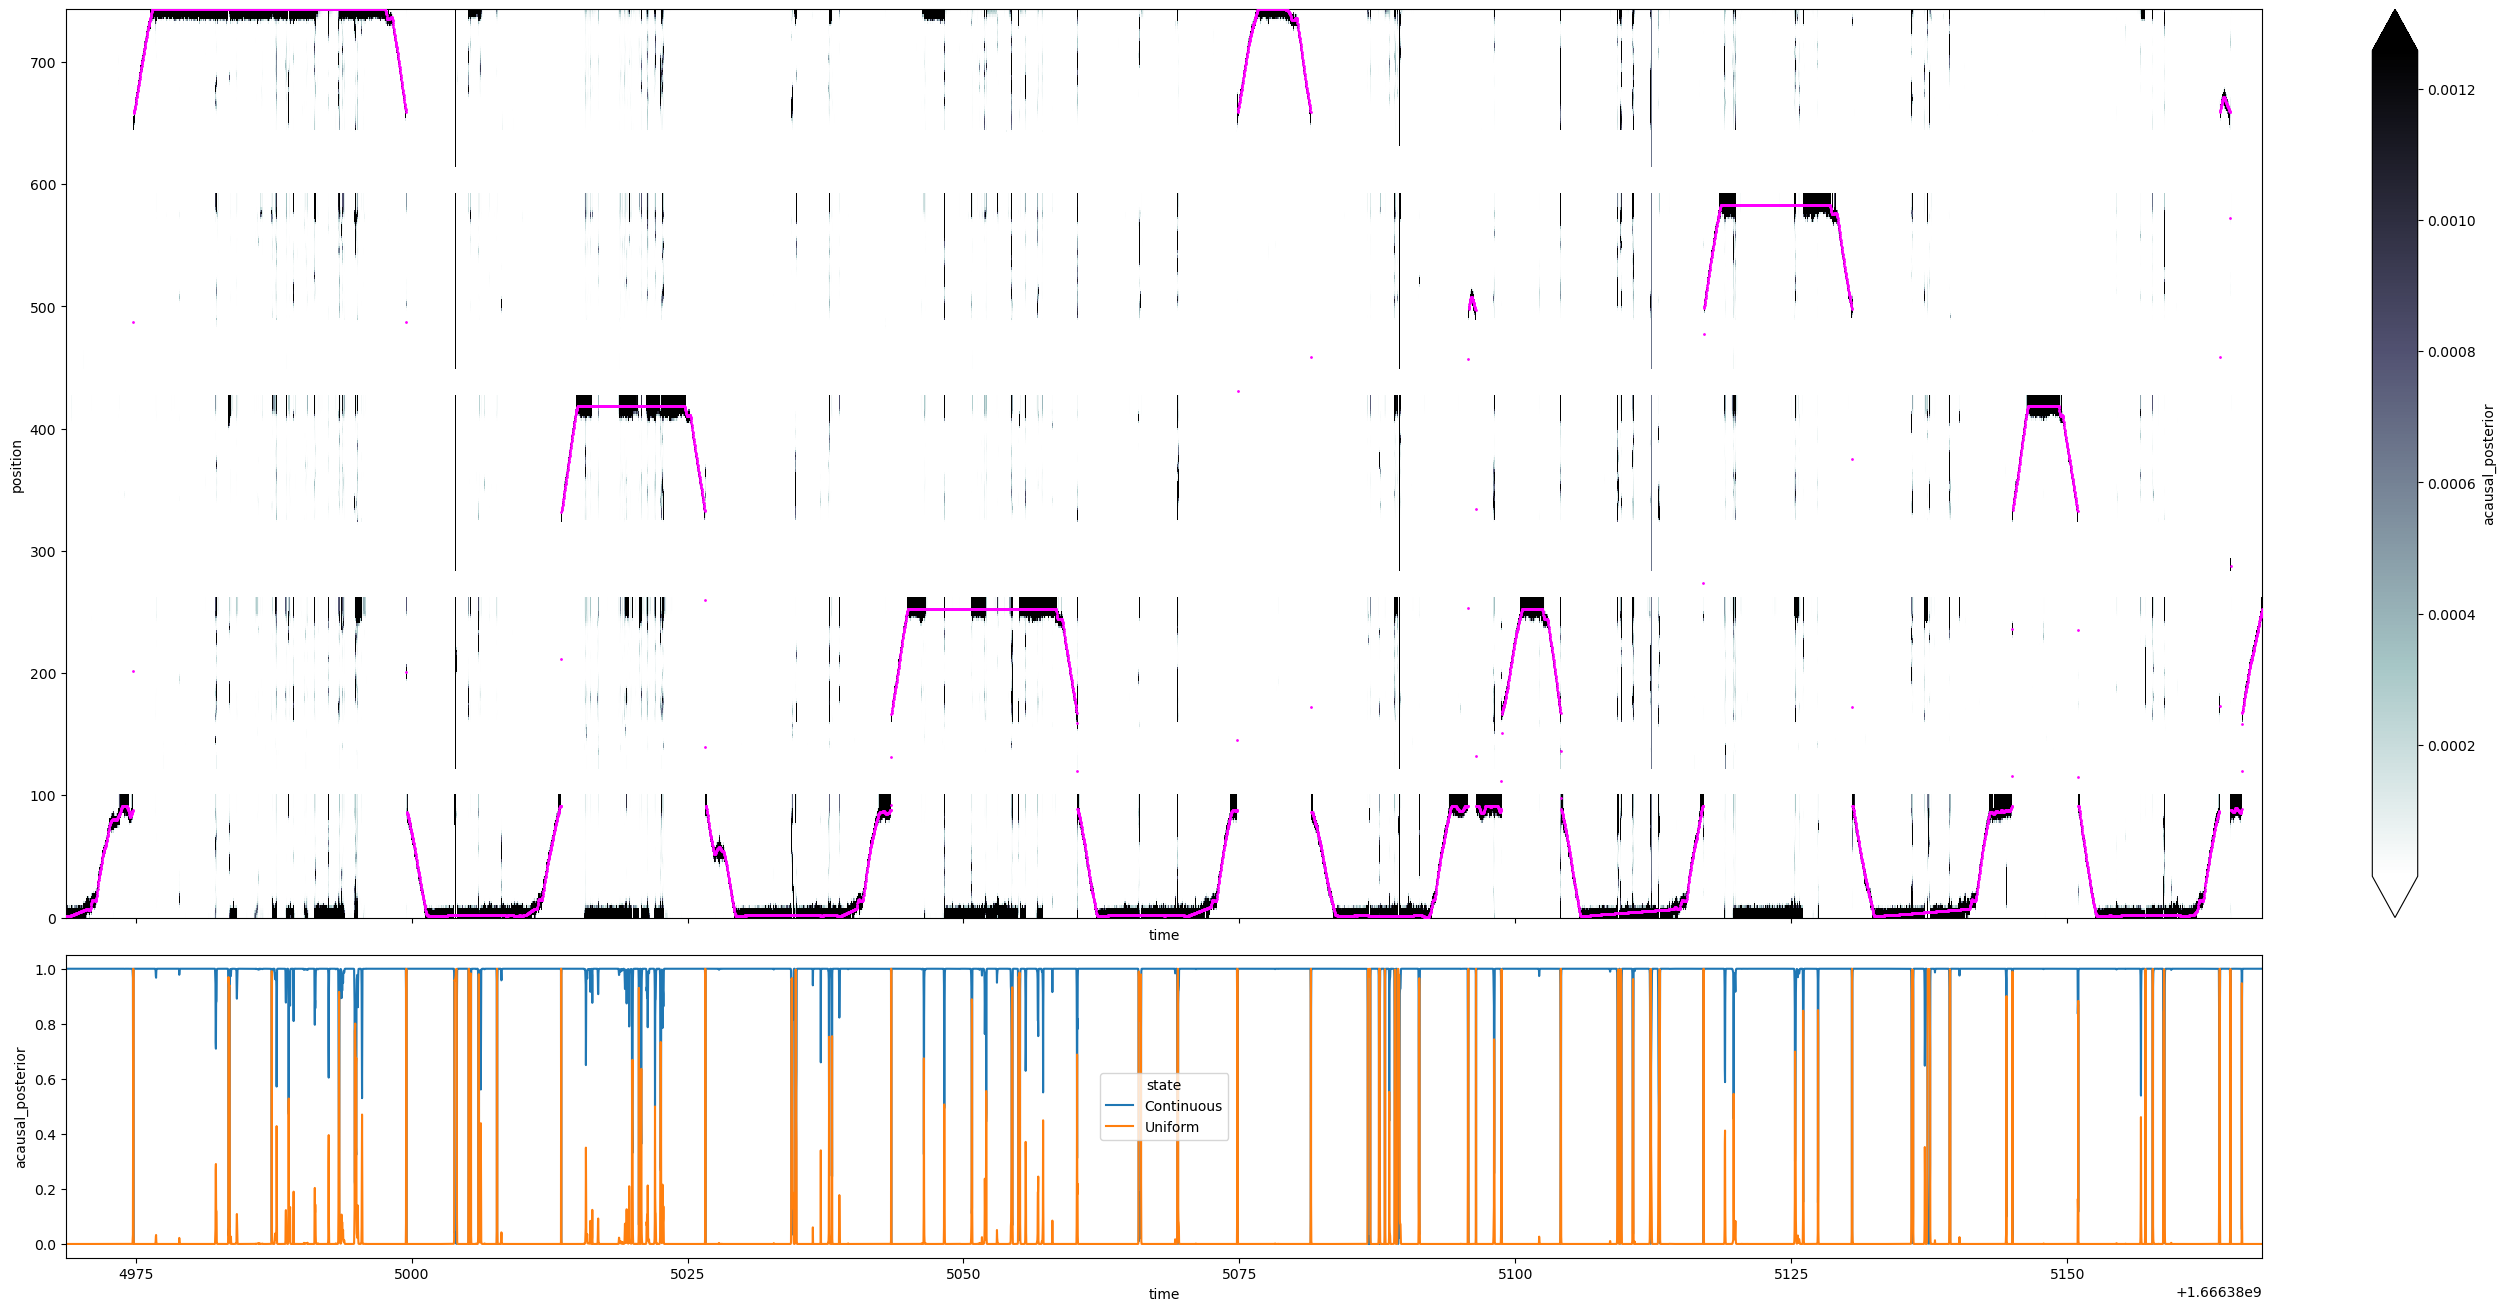

In [155]:
import matplotlib.pyplot as plt

time_slice = slice(100_050, 110_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].time,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

In [122]:
results.time[1] - results.time[0]

<xarray.DataArray 'time' ()>
array(0.00999975)

TypeError: No numeric data to plot.

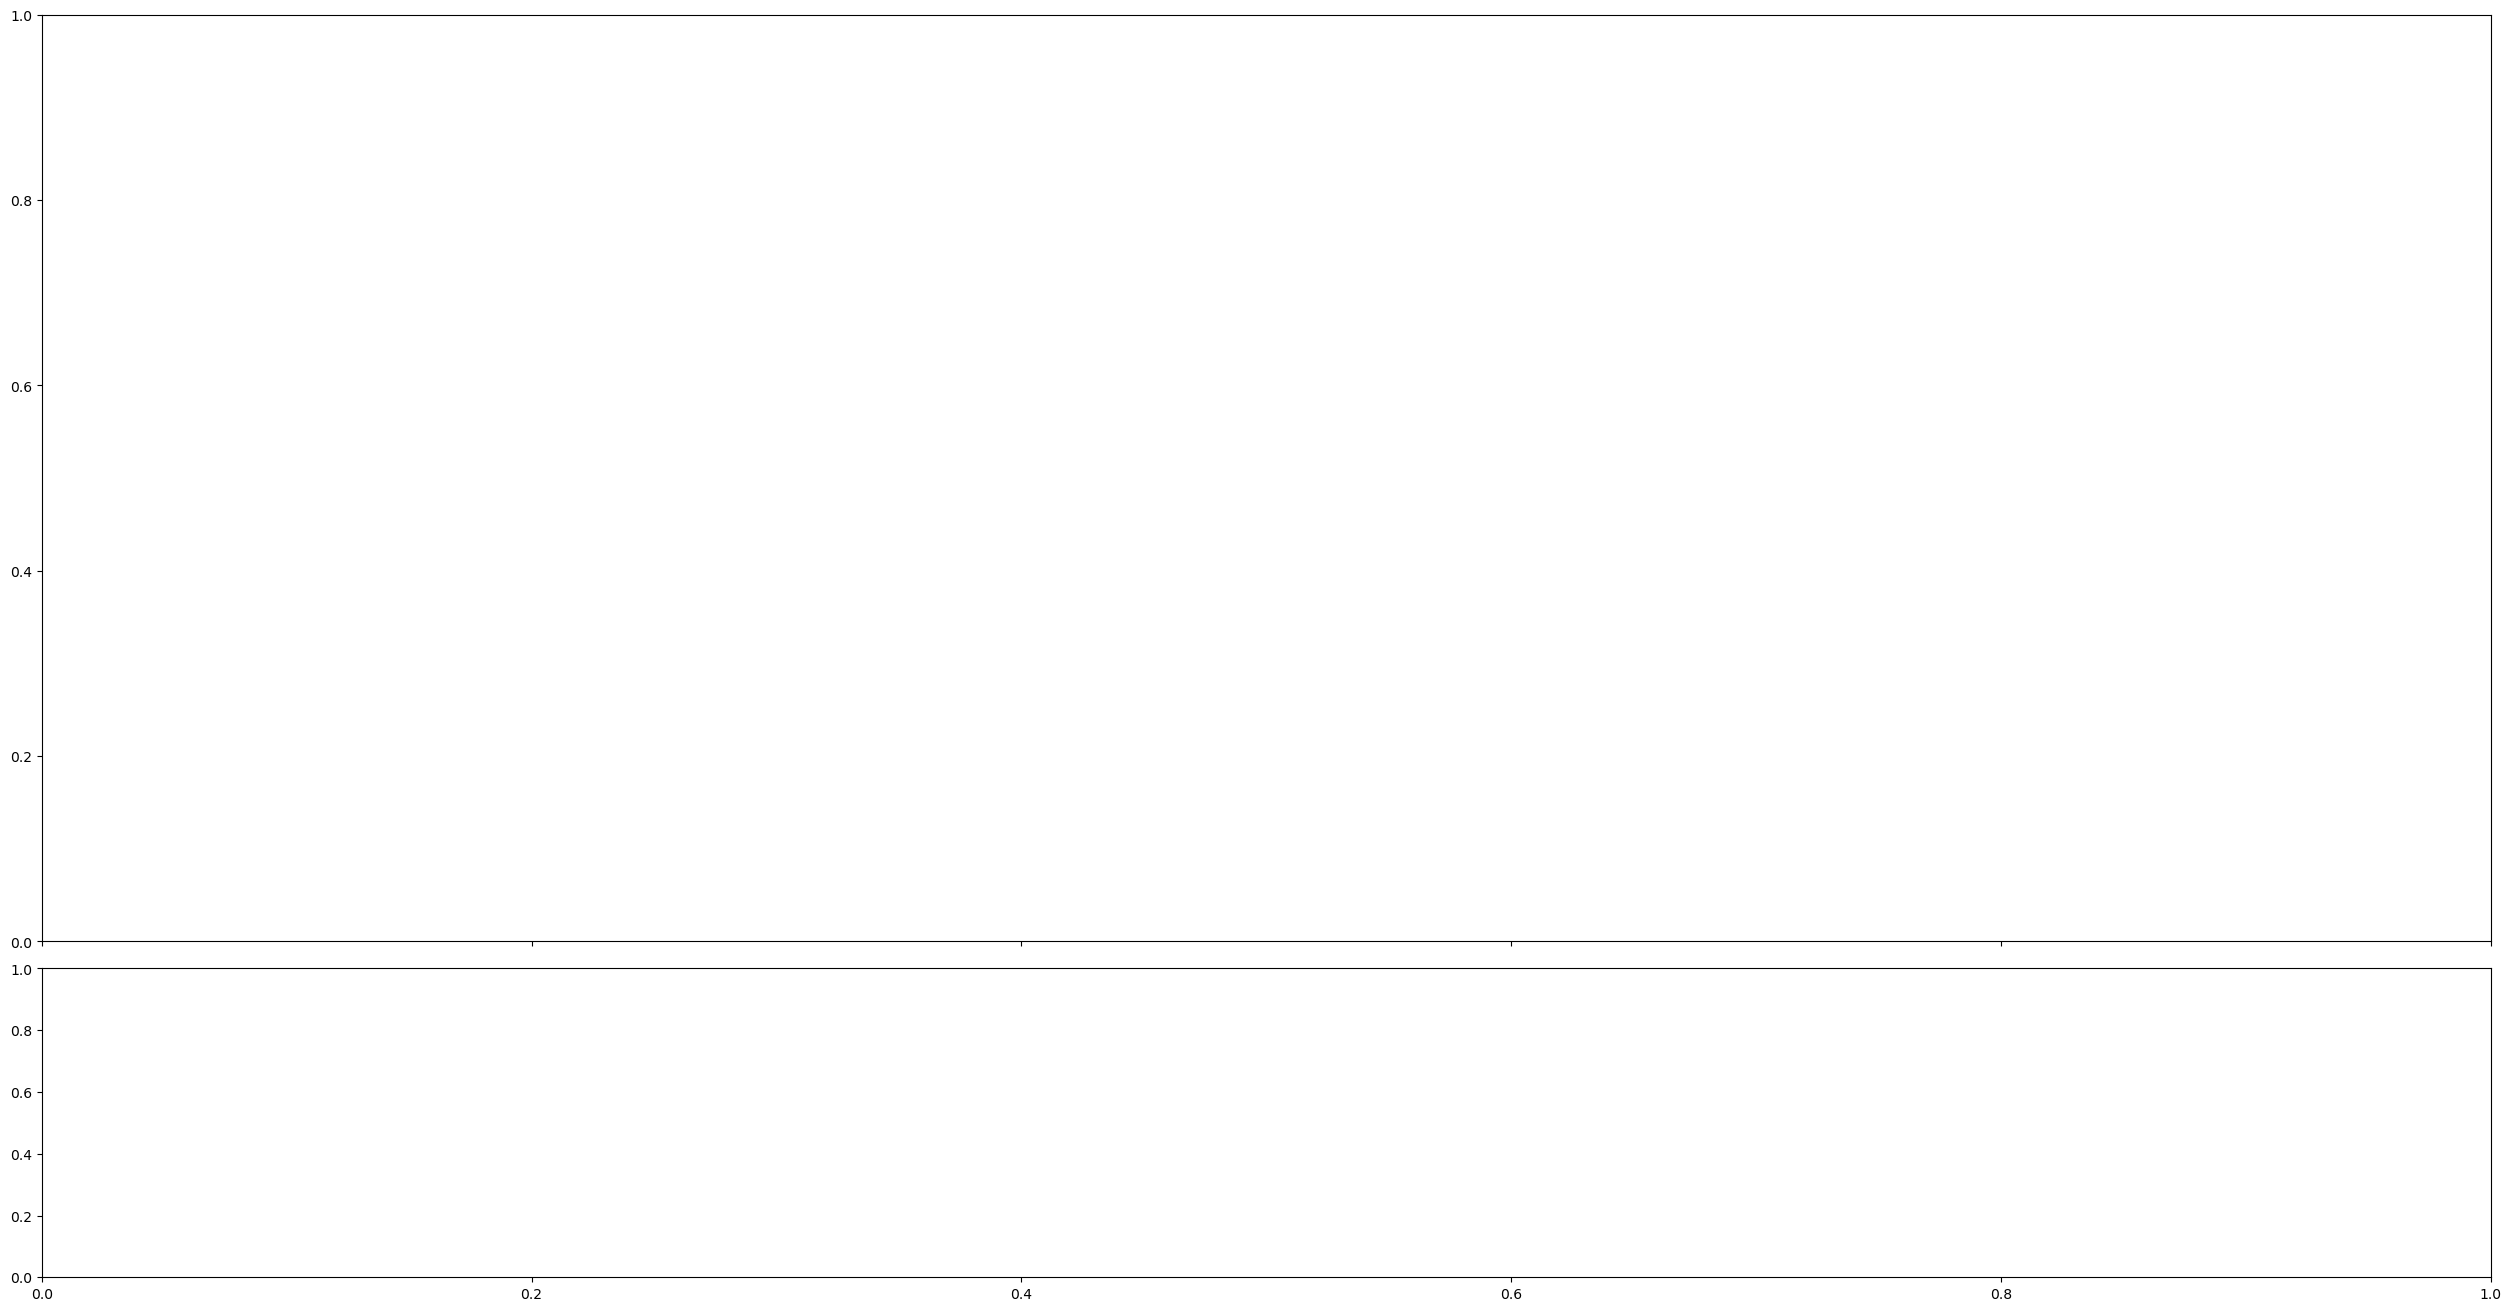

In [182]:
import matplotlib.pyplot as plt

time_slice = slice(102_000, 102_000 + 1000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).likelihood.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].time,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).likelihood.sum('position').plot(x='time', hue='state', ax=axes[1])

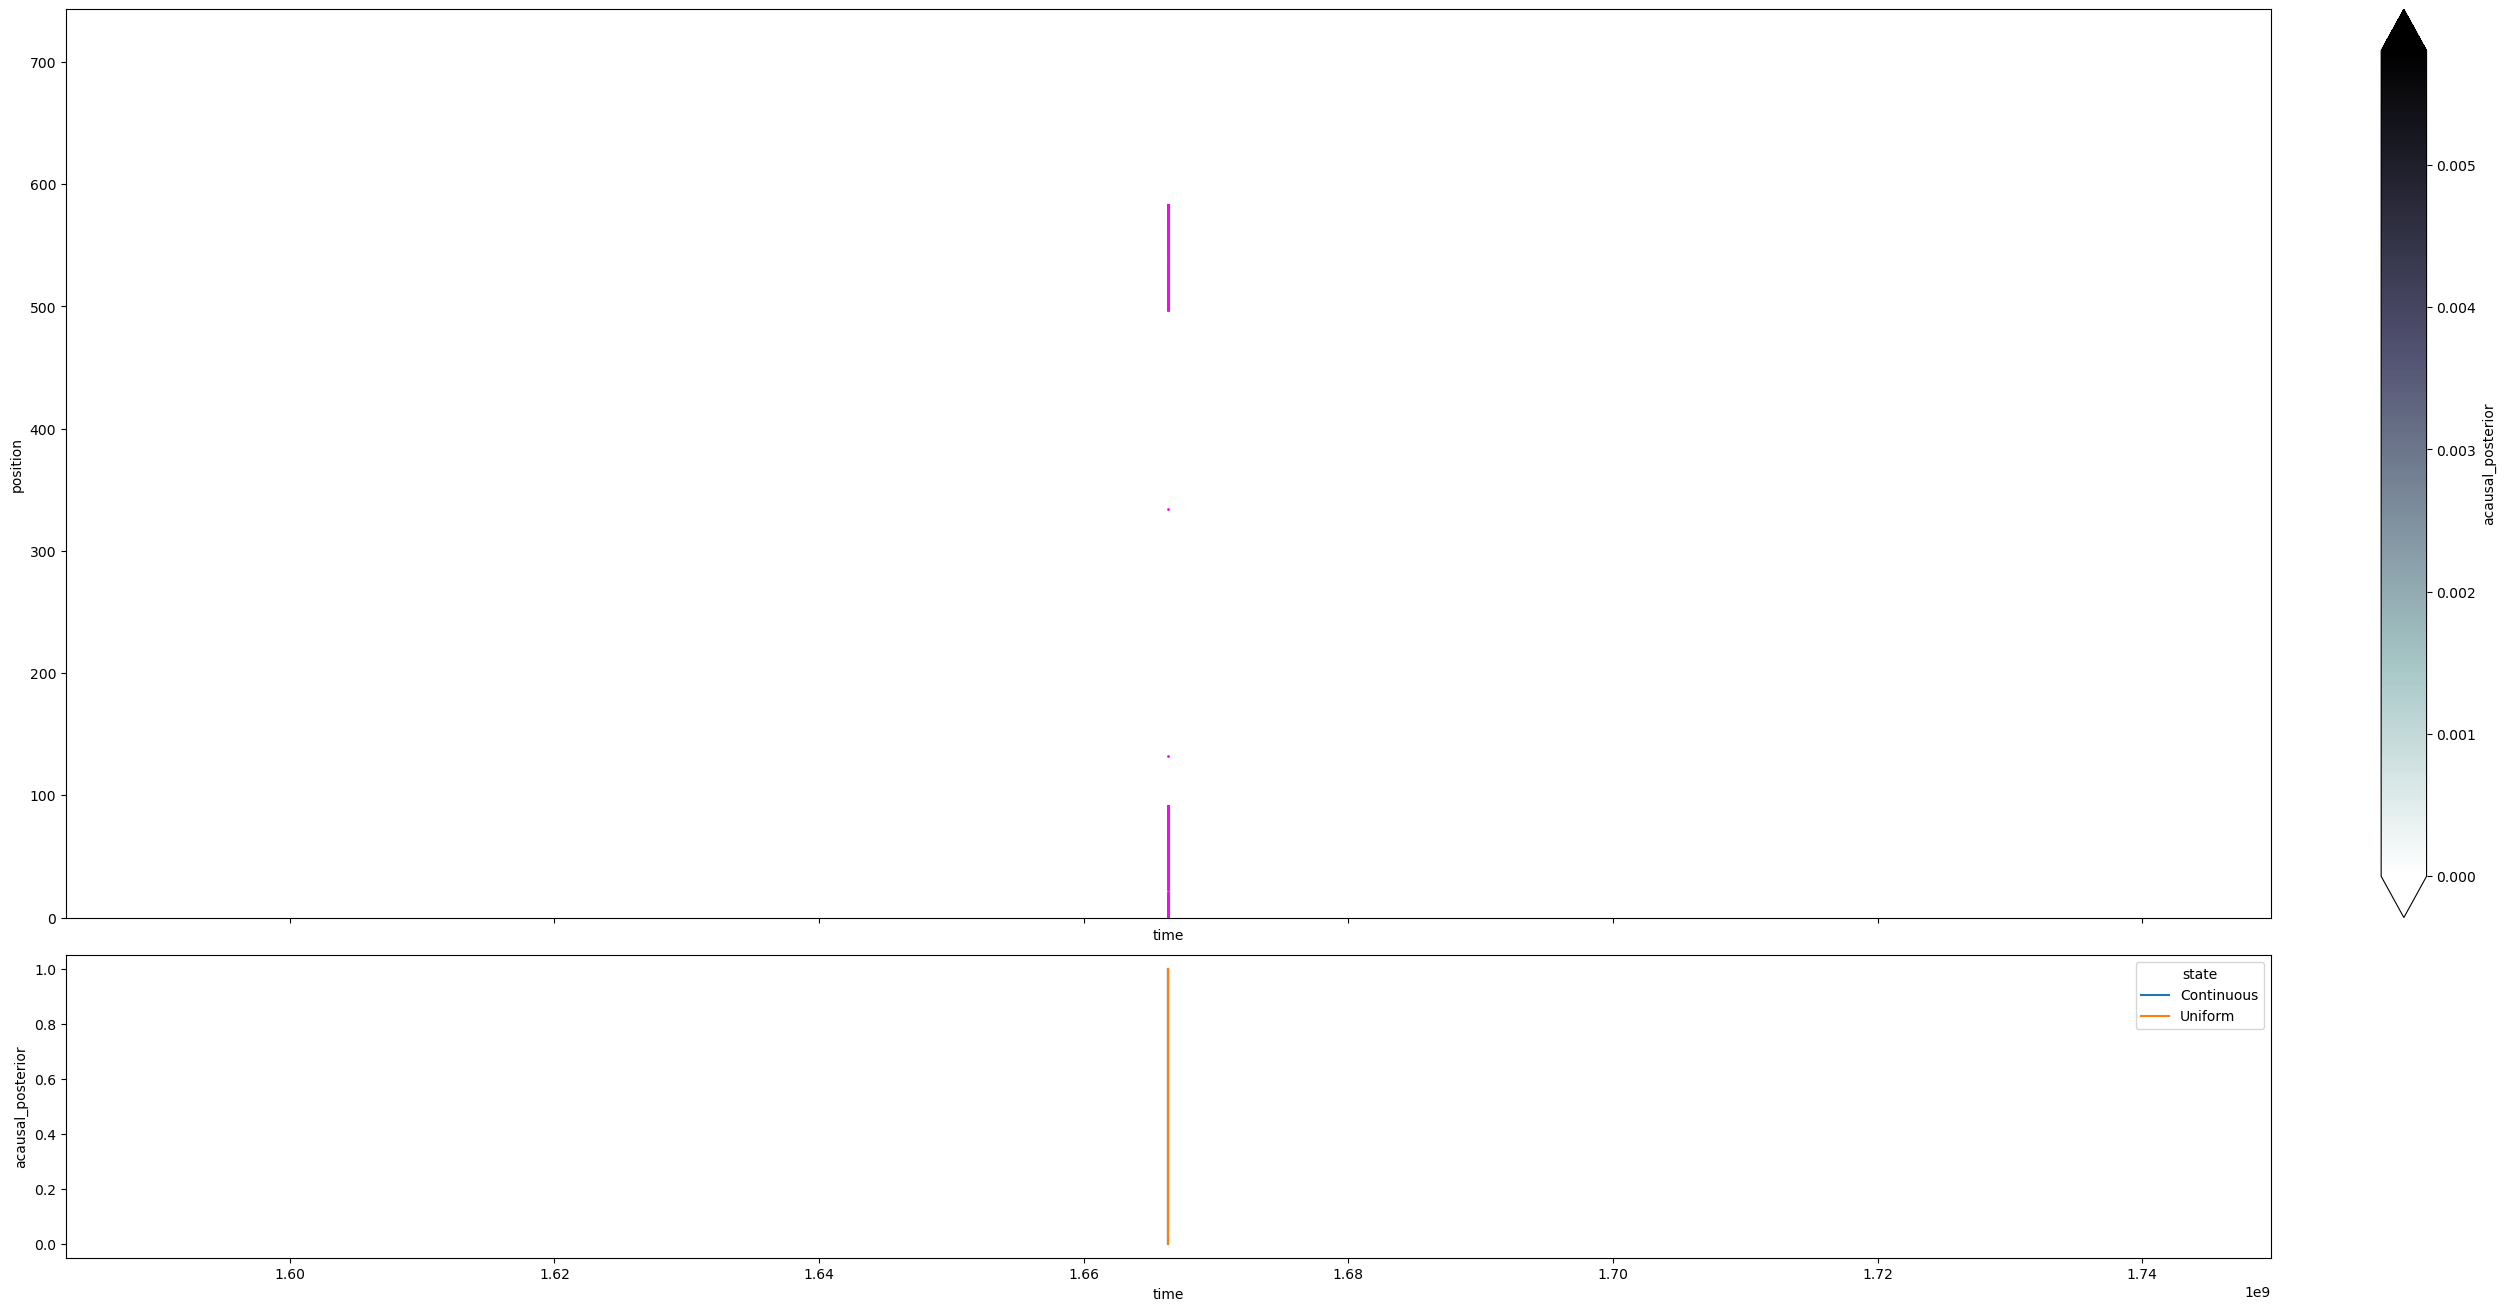

In [48]:
import matplotlib.pyplot as plt

time_slice = slice(180_000, 190_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].time,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

TypeError: No numeric data to plot.

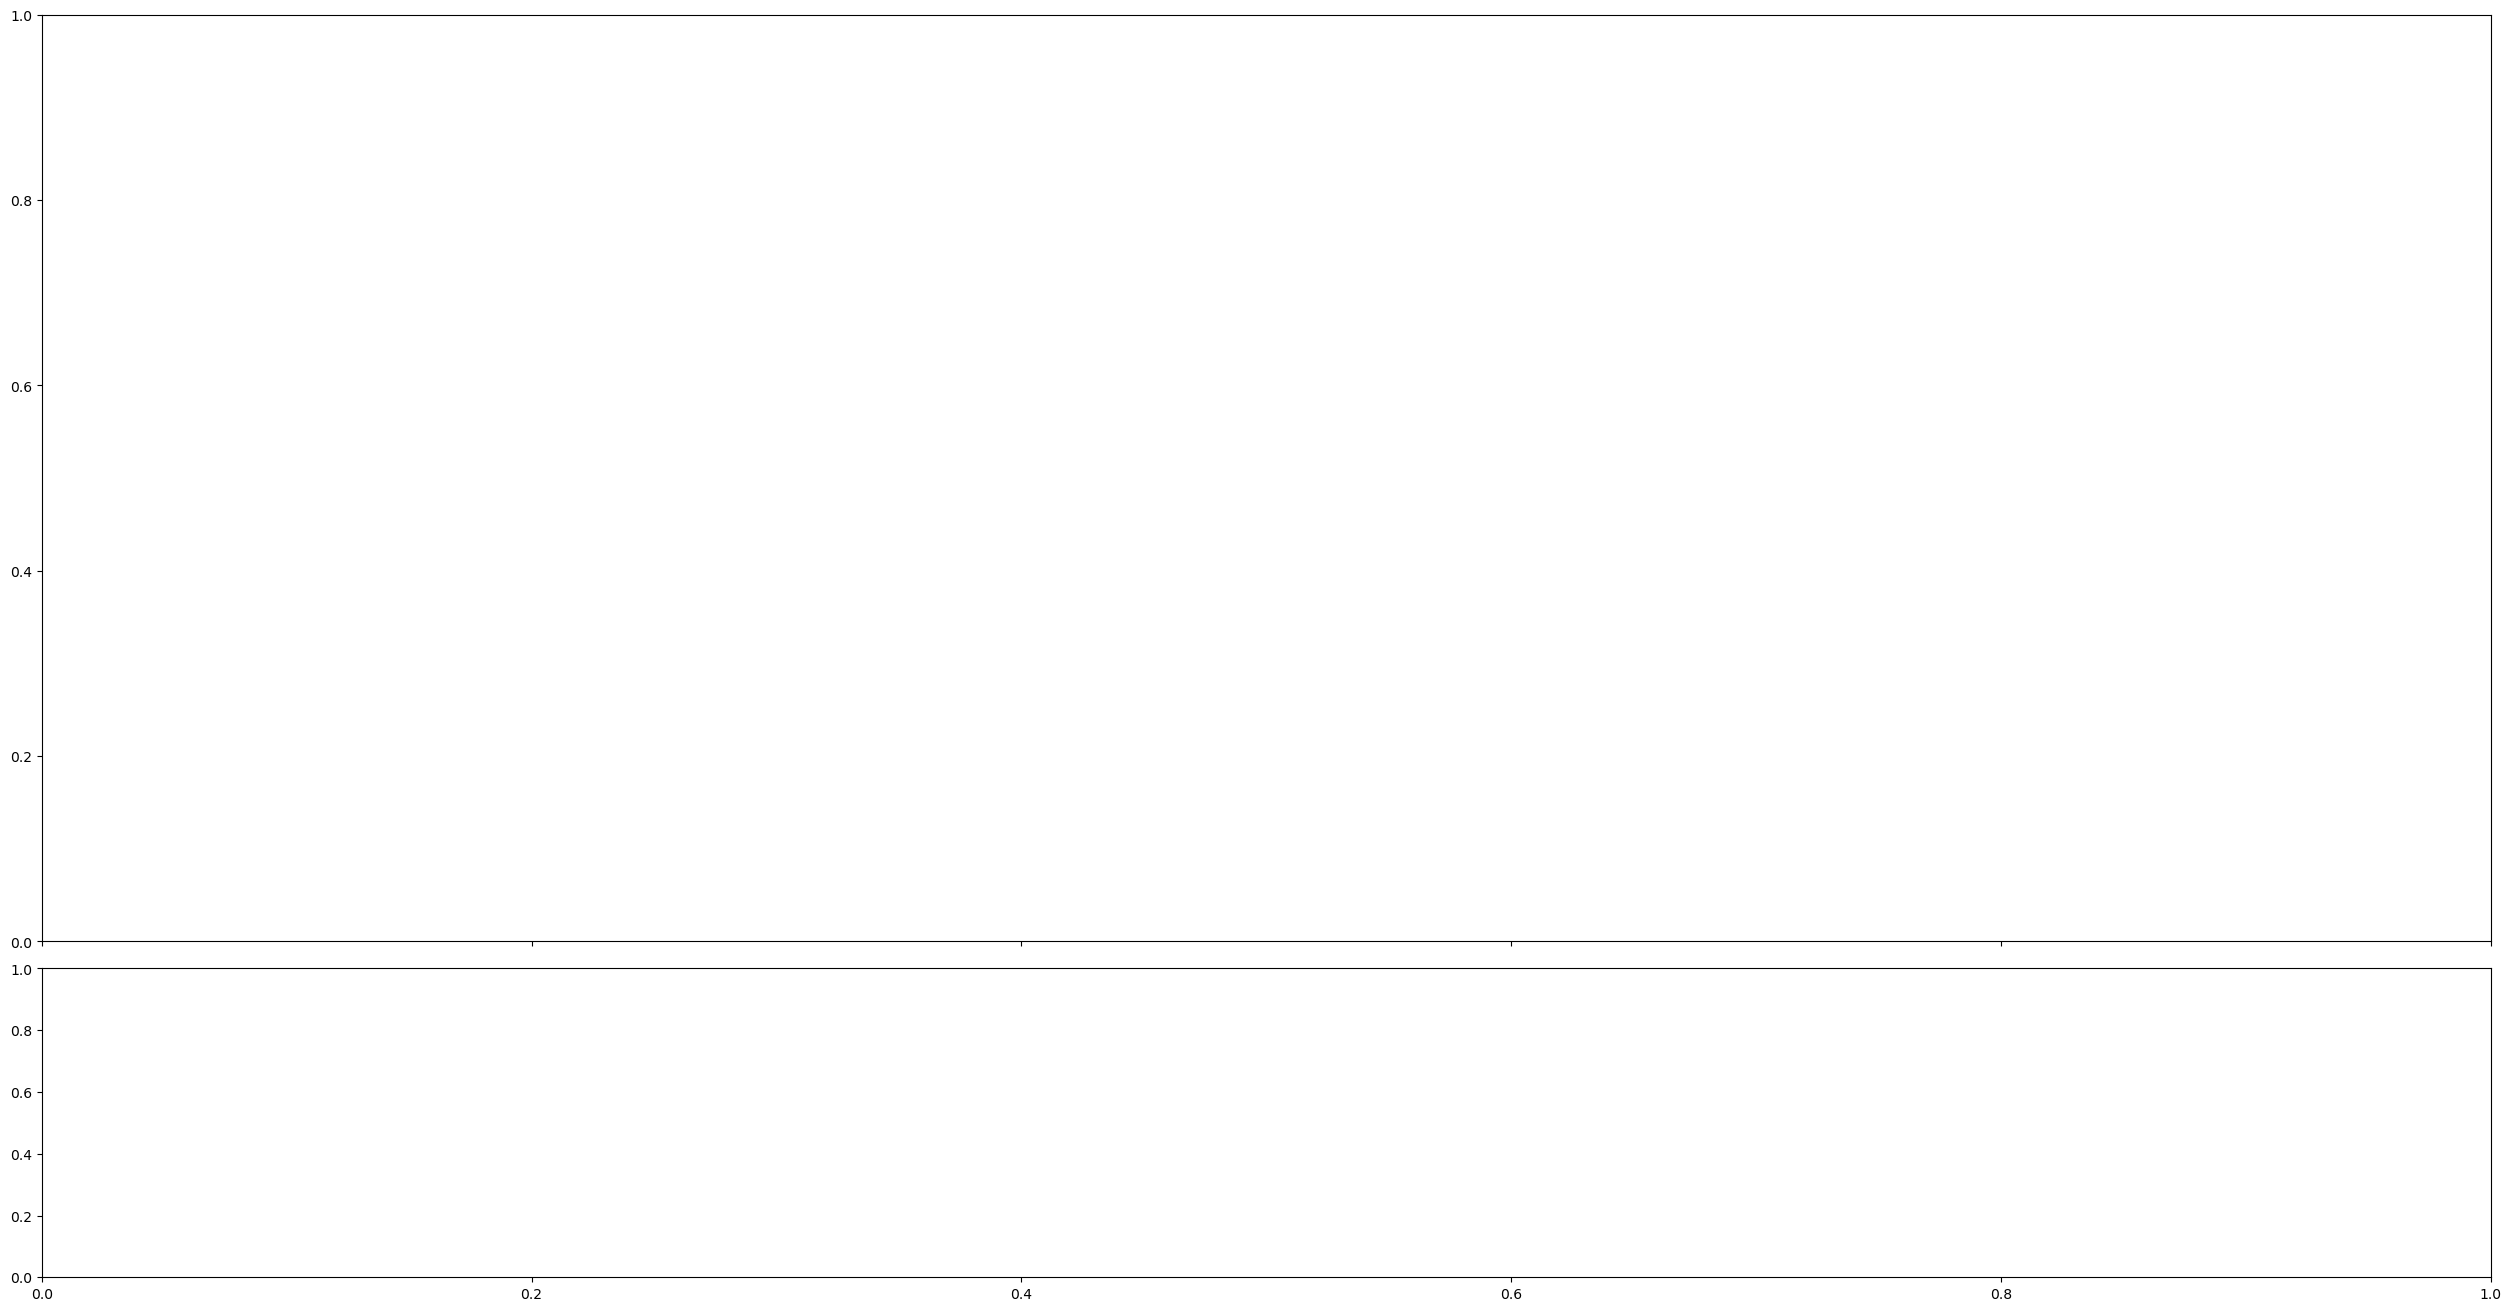

In [49]:
import matplotlib.pyplot as plt

time_slice = slice(230_000, 240_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].time,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

In [91]:
from trajectory_analysis_tools import get_trajectory_data, get_ahead_behind_distance

trajectory_data = get_trajectory_data(
    results.sum('state').acausal_posterior,
    track_graph,
    classifier,
    linear_position_df[['projected_x_position', 'projected_y_position']],
    linear_position_df.track_segment_id,
    position_info.head_orientation,
)

ahead_behind_distance = get_ahead_behind_distance(
    track_graph, *trajectory_data)
mental_position_edges = trajectory_data[-1]
mental_position_edge_id = np.asarray(
    [track_graph.edges[edge]['edge_id'] for edge in mental_position_edges])

NameError: name 'position_info' is not defined

In [30]:
from ripple_detection import get_multiunit_population_firing_rate

SAMPLING_FREQUENCY = 500

multiunit_spikes = (np.any(~np.isnan(marks.values), axis=1)
                    ).astype(float)
multiunit_firing_rate = pd.DataFrame(
    get_multiunit_population_firing_rate(
        multiunit_spikes, SAMPLING_FREQUENCY), index=marks.time,
    columns=['firing_rate'])

In [31]:
from ripple_detection import multiunit_HSE_detector

multiunit_high_synchrony_times = multiunit_HSE_detector(
    marks.time.values,
    multiunit_spikes,
    position_info.head_speed.values,
    sampling_frequency=SAMPLING_FREQUENCY,
    minimum_duration=0.015,
    zscore_threshold=2.0,
    close_event_threshold=0.000)

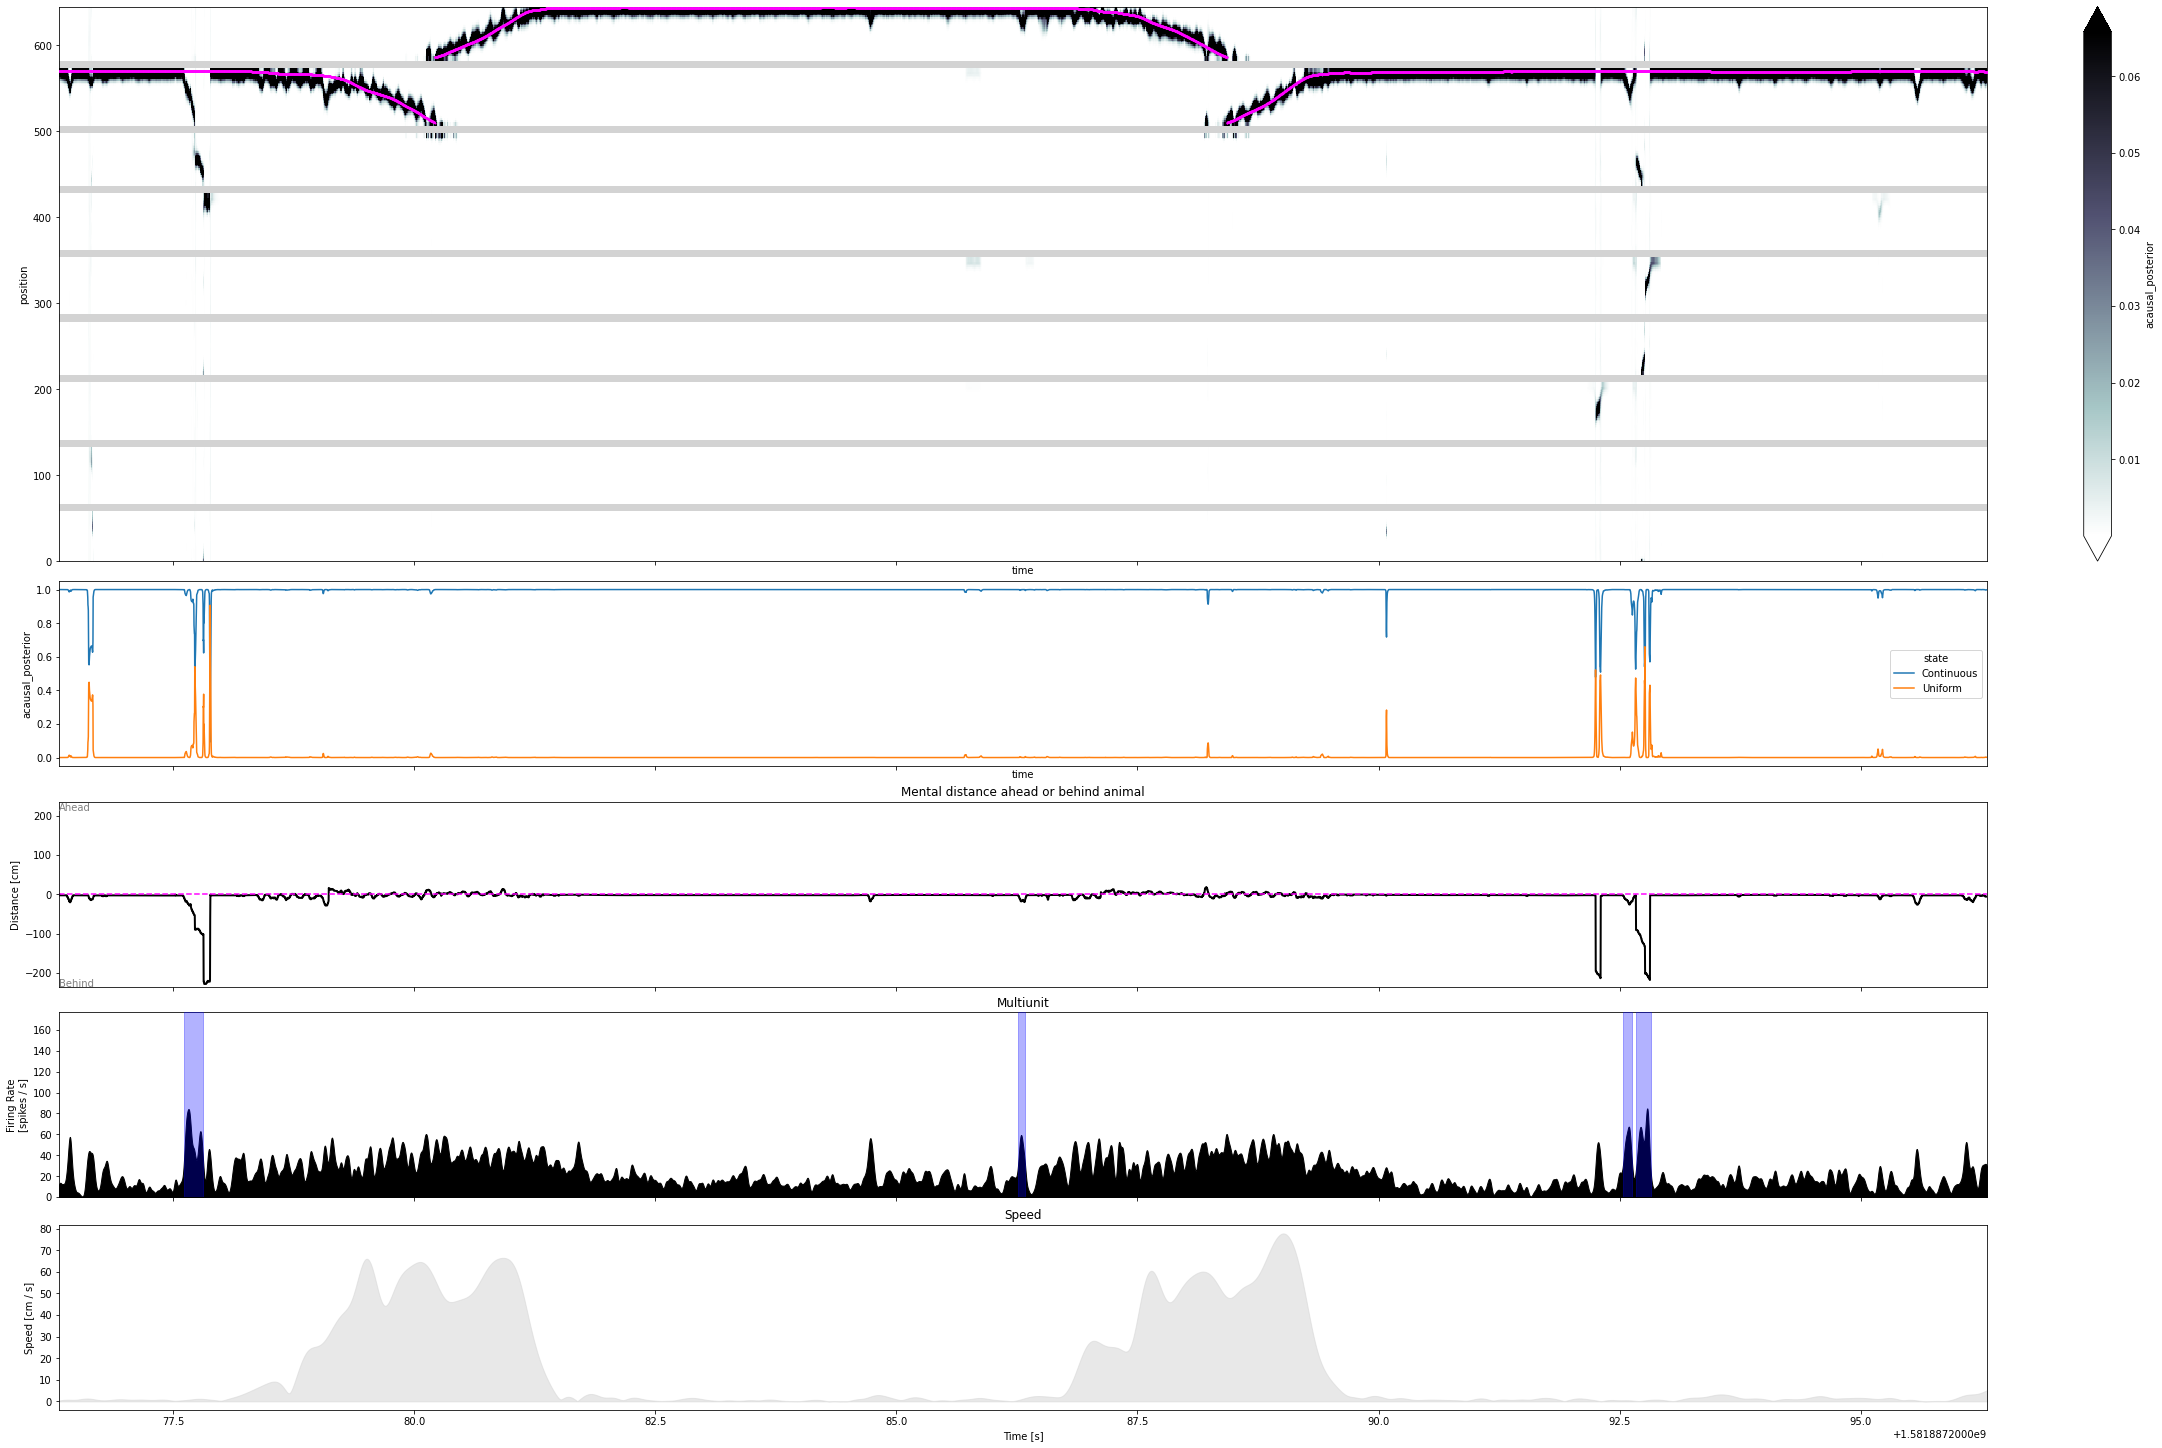

In [32]:
import matplotlib.pyplot as plt
import copy


def plot_classifier(
    time_slice,
    results,
    classifier,
    position_info,
    linear_position_df,
    ahead_behind_distance,
    multiunit_firing_rate,
    multiunit_high_synchrony_times,
    cmap='bone_r',
    figsize=(30, 20)
):

    cmap = copy.copy(plt.cm.get_cmap(cmap))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    fig, axes = plt.subplots(5, 1, figsize=figsize, sharex=True, constrained_layout=True,
                             gridspec_kw={"height_ratios": [3, 1, 1, 1, 1]},)

    time = results.isel(time=time_slice).time
    (results
     .isel(time=time_slice)
     .acausal_posterior
     .sum('state')
     .where(classifier.environments[0].is_track_interior_)
     .plot(x='time', y='position', ax=axes[0], robust=True, cmap=cmap))
    axes[0].scatter(time,
                    linear_position_df.iloc[time_slice].linear_position.values,
                    s=1, color='magenta', zorder=10)

    results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])
    axes[2].plot(time,
                 ahead_behind_distance[time_slice],
                 color="black", linewidth=2)
    axes[2].axhline(0, color="magenta", linestyle="--")
    axes[2].set_title("Mental distance ahead or behind animal")
    axes[2].set_ylabel("Distance [cm]")
    max_dist = np.max(np.abs(ahead_behind_distance)) + 5
    axes[2].set_ylim((-max_dist, max_dist))
    axes[2].text(time[0], max_dist - 1, "Ahead", color="grey", va='top')
    axes[2].text(time[0], -max_dist + 1, "Behind", color="grey")

    # ax 3
    axes[3].fill_between(
        multiunit_firing_rate.iloc[time_slice].index.values,
        multiunit_firing_rate.iloc[time_slice].values.squeeze(),
        color="black",
    )
    axes[3].set_ylabel("Firing Rate\n[spikes / s]")
    axes[3].set_title("Multiunit")
    axes[3].set_ylim((0.0, np.max(np.asarray(multiunit_firing_rate))))


    cur_multiunit_HSE = interval_list_intersect(
        np.asarray(multiunit_high_synchrony_times),
        np.asarray([(time[0], time[-1])]))

    for start_time, end_time in cur_multiunit_HSE:
        axes[3].axvspan(start_time, end_time, color='blue', alpha=0.3, zorder=10)

    # ax 4
    axes[4].fill_between(
        time,
        position_info.iloc[time_slice]
        .head_speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[4].set_title('Speed')
    axes[4].set_ylabel("Speed [cm / s]")
    axes[4].set_xlabel("Time [s]")
    

time_slice = slice(180_000, 190_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)

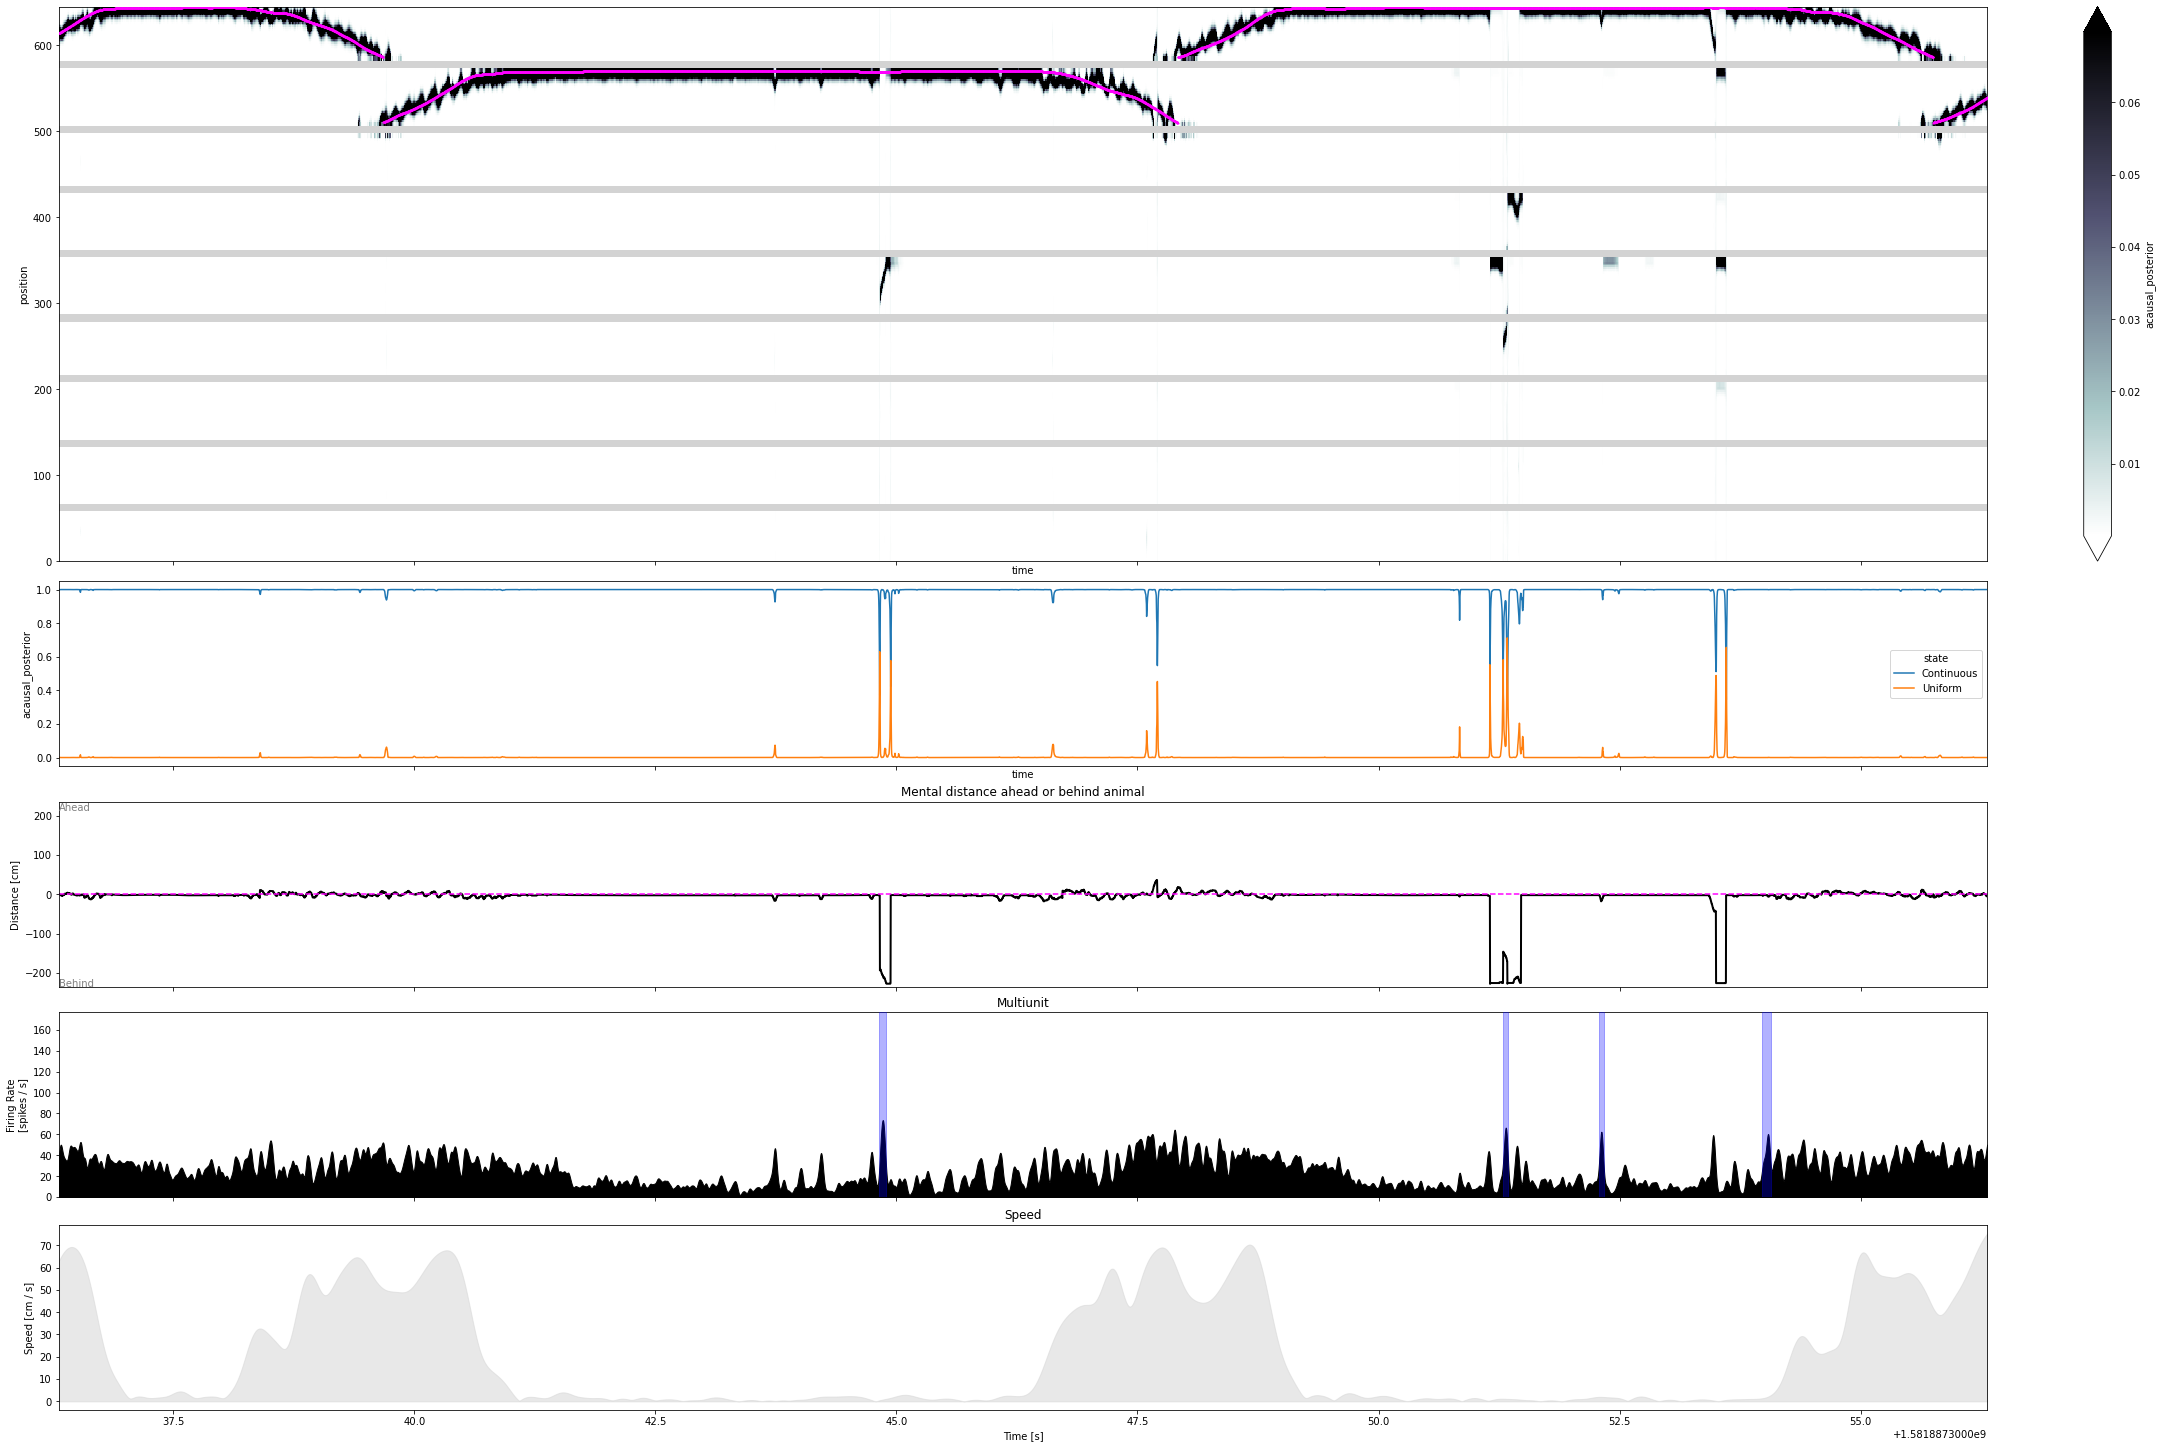

In [33]:
time_slice = slice(210_000, 220_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)

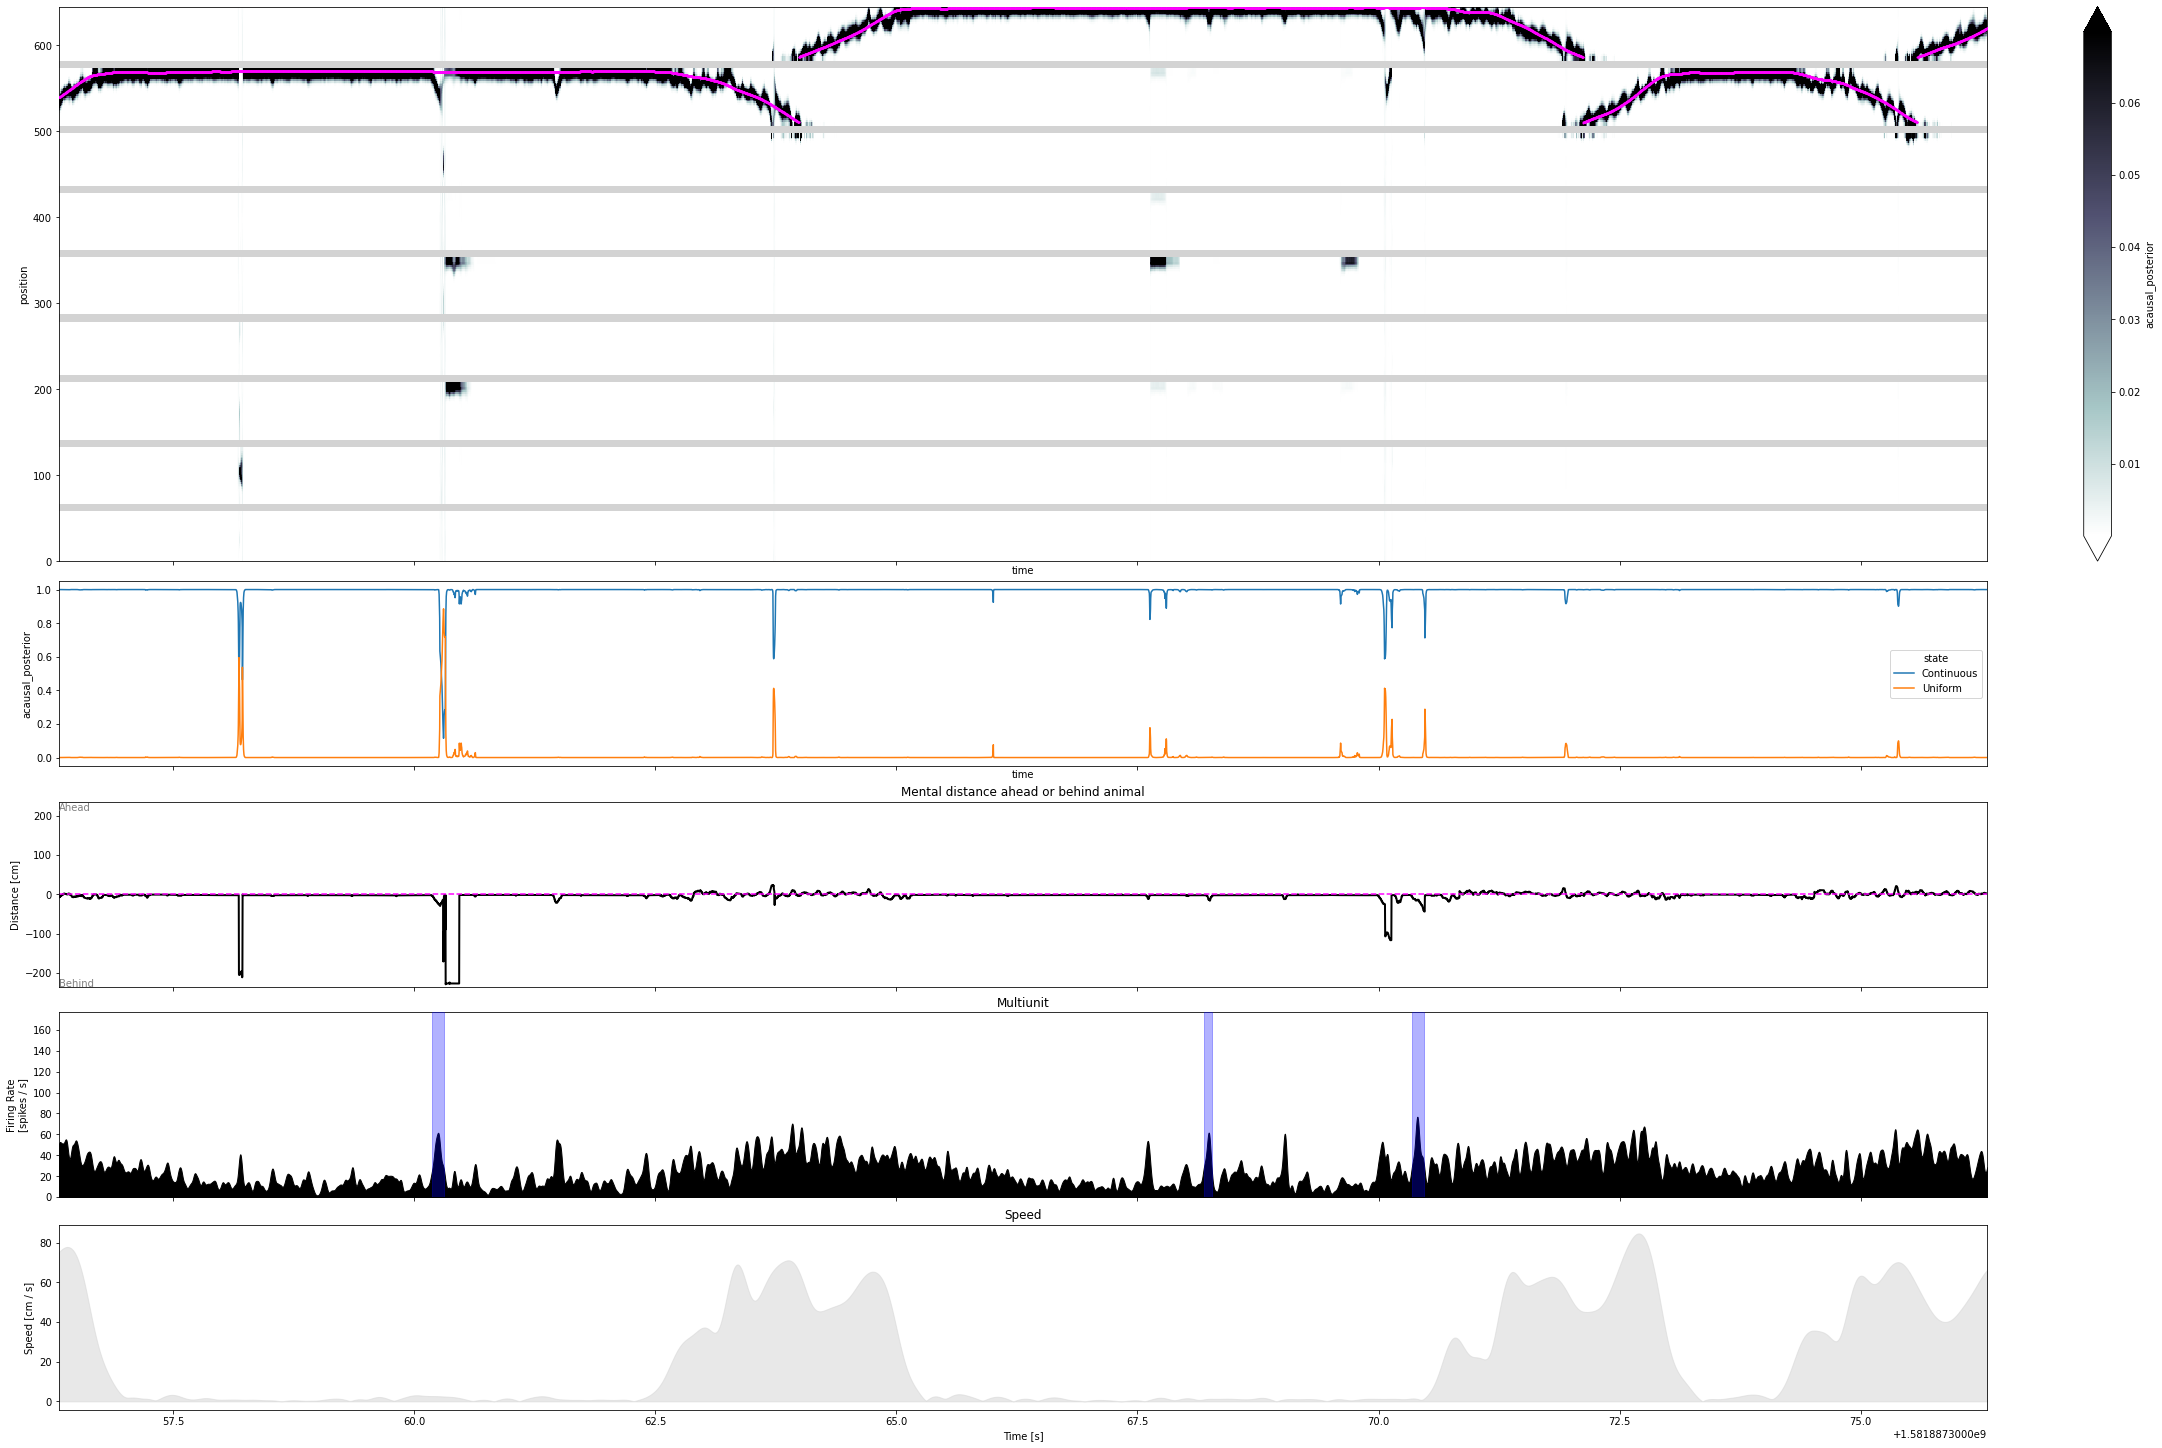

In [34]:
time_slice = slice(220_000, 230_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)